# This notebook demonstrates the use of DEMV pre-processing algorithm for bias mitigation

_Debiaser for Multiple Variables (DEMV)_ is a pre-processing algorithm to mitigate the bias of binary and multi-class datasets (i.e., datasets where the label has more than 2 values) with any number of sensitive variables.
This algorithm works by perfectly rebalance the sensitive groups of the dataset identified by the combination of all the values of the sensitive variables and all the values of the label [1].

 [1] G. d'Aloisio, A. D'Angelo, A. Di Marco, e G. Stilo, «Debiaser for Multiple Variables to enhance fairness in classification tasks», Information Processing & Management, vol. 60, mar. 2023, doi: 10.1016/j.ipm.2022.103226.

In [2]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.demv import DEMV
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

%load_ext autoreload
%autoreload 2

## Load dataset and set options

**Note** 

In this example we use DEMV on binary classification datasets. However, DEMV can be used on multi-class classification datasets as well.

In [3]:
## import dataset
dataset_used = "adult" #"adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

#### Split into train, and test

In [4]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Clean up training data

In [5]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


## Metric for original training data

In [6]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
print("Disparate Impact between unprivileged and privileged groups = %f" % metric_orig_train.disparate_impact())
print("Statistical Parity difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244
Disparate Impact between unprivileged and privileged groups = 0.367778
Statistical Parity difference between unprivileged and privileged groups = -0.190244


### Train and transform the original training data

DEMV is a pre-processing algorithm, meaning that it works directly on the dataset by rebalancing all its sensitive groups.

Here we instantiate DEMV and transform the training data.

In [7]:
demv = DEMV()

In [8]:
newdata = demv.fit_transform(dataset_orig_train)

#### Metric with the transformed training data

In [9]:
metric_transf_train = BinaryLabelDatasetMetric(newdata, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Disparate Impact between unprivileged and privileged groups = %f" % metric_transf_train.disparate_impact())
print("Statistical Parity difference between unprivileged and privileged groups = %f" % metric_transf_train.statistical_parity_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.036211
Disparate Impact between unprivileged and privileged groups = 0.858829
Statistical Parity difference between unprivileged and privileged groups = -0.036211


In [10]:
assert np.abs(metric_orig_train.disparate_impact()) < np.abs(metric_transf_train.disparate_impact())

In [11]:
assert np.abs(metric_orig_train.statistical_parity_difference()) > np.abs(metric_transf_train.statistical_parity_difference())

We can change the `round_level` parameter for a more fine-grained balancing of the groups.

In [17]:
demv_fine = DEMV(round_level=3)
newdata = demv_fine.fit_transform(dataset_orig_train)

In [18]:
metric_transf_train = BinaryLabelDatasetMetric(newdata, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Disparate Impact between unprivileged and privileged groups = %f" % metric_transf_train.disparate_impact())
print("Statistical Parity difference between unprivileged and privileged groups = %f" % metric_transf_train.statistical_parity_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000299
Disparate Impact between unprivileged and privileged groups = 0.998746
Statistical Parity difference between unprivileged and privileged groups = -0.000299


Note that if we specify a `round_level` that is too high, the algorithm will not be able to perfectly balance the groups and a warning will be raised.

In [23]:
demv_high = DEMV(round_level=5)
newdata_high = demv_high.fit_transform(dataset_orig_train)

In [24]:
metric_transf_train = BinaryLabelDatasetMetric(newdata_high, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Disparate Impact between unprivileged and privileged groups = %f" % metric_transf_train.disparate_impact())
print("Statistical Parity difference between unprivileged and privileged groups = %f" % metric_transf_train.statistical_parity_difference())

#### Transformed training dataset

Disparate Impact between unprivileged and privileged groups = 0.996138
Statistical Parity difference between unprivileged and privileged groups = -0.000919


## Train a classifier algorithm

Since DEMV does not use the instance weights, we can use it with any classifier algorithm. 

In this case we train a MLP classifier.

#### Metrics with original data

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dataset_orig_train.features = scaler.fit_transform(dataset_orig_train.features)
newdata.features = scaler.transform(newdata.features) 

model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=100, alpha=1e-4)
model.fit(dataset_orig_train.features, dataset_orig_train.labels.ravel())
pred_origin = model.predict(dataset_orig_test.features)

In [15]:
dataset_pred_origin = dataset_orig_test.copy()
dataset_pred_origin.labels = pred_origin

In [16]:
origin_class_metric = ClassificationMetric(dataset_orig_test, dataset_pred_origin, unprivileged_groups, privileged_groups)
display(Markdown("#### Original dataset prediction metrics"))
print("Equal opportunity %f" % origin_class_metric.equal_opportunity_difference())

#### Original dataset prediction metrics

Equal opportunity -0.490658


#### Metrics with transformed data

In [19]:
model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=100, alpha=1e-4)
model.fit(newdata.features, newdata.labels.ravel())
pred_trans = model.predict(dataset_orig_test.features)

In [20]:
dataset_pred_trans = dataset_orig_test.copy()
dataset_pred_trans.labels = pred_trans

In [21]:
trans_class_metric = ClassificationMetric(
    dataset_orig_test, 
    dataset_pred_trans, 
    unprivileged_groups, 
    privileged_groups)
display(Markdown("#### Transformed dataset prediction metrics"))
print("Equal opportunity %f" % trans_class_metric.equal_opportunity_difference())

#### Transformed dataset prediction metrics

Equal opportunity -0.092000


In [22]:
assert np.abs(trans_class_metric.equal_opportunity_difference()) < np.abs(origin_class_metric.equal_opportunity_difference())

## Plot the balancing of the groups

To have a graphical representation of the behavior of DEMV, we can plot the ratio between the expected size ($W_{exp}$) and the observed size ($W_{obs}$) of each sensitive group at each balancing iteration.

In [25]:
import seaborn as sns
def plot_groups_disparity(disparities):
    fig, ax = plt.subplots()
    for d in disparities:
        sns.lineplot(data=d)
    plt.axhline(y=1, linewidth=2)
    ax.set_ylabel('Group disparity')
    return ax

..\aif360\algorithms\preprocessing\demv.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.disparities)


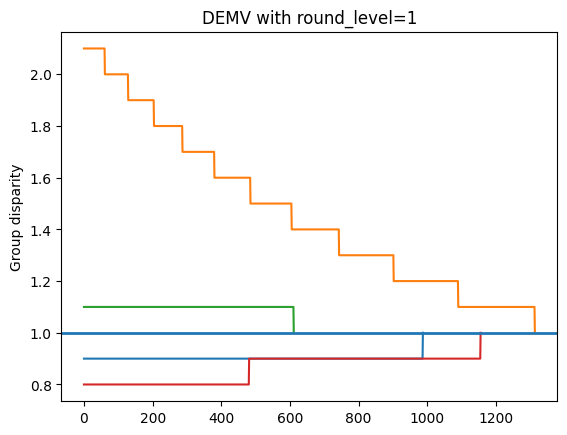

In [27]:
plot_groups_disparity(demv.get_disparities()[0])
plt.title("DEMV with round_level=1")
plt.show()

..\aif360\algorithms\preprocessing\demv.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.disparities)


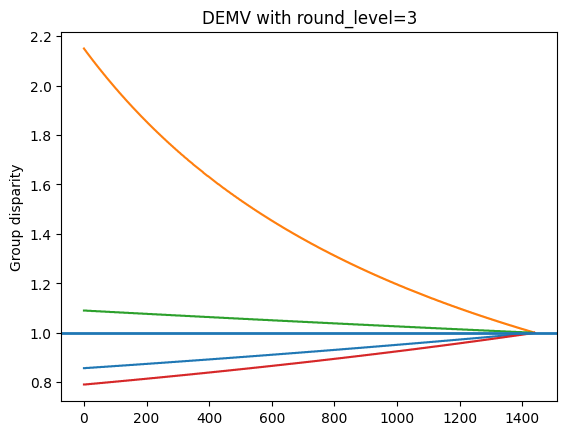

In [28]:
plot_groups_disparity(demv_fine.get_disparities()[0])
plt.title("DEMV with round_level=3")
plt.show()

In [29]:
demv_fine.get_iters()

1440

After 1440 iterations, $W_{exp}/W_{obs}$ of all the groups converges to one. This means that all the groups are totally balanced.
